In [1234]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import plotly.graph_objects as go
from prophet import Prophet
from sklearn import metrics
import plotly.express as px
import lightgbm as lgb
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [1235]:
df_one = pd.read_csv('time_series_covid_19_recovered.csv')

In [1236]:
df_one.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,33,34,34,35,35,35,35,41,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,101,118,118,118,118,118,144,144,144,150
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,96,96,97,105,105,109,114,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,24,26,26,26,35,42,42,49,60,75


In [1237]:
df_two=pd.read_csv("time_series_covid_19_deaths.csv")
df_two=pd.melt(df_two,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Deadths')
df_two.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
df_two['Date']=pd.to_datetime(df_two['Date'])

Приводим колонки к нужному формату

In [1238]:
def melt_and_merge(agg=True):

    df_one = pd.read_csv('time_series_covid_19_recovered.csv')
    df_one=pd.melt(df_one,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Recovered')
    df_one.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_one['Date']=pd.to_datetime(df_one['Date'])

    df_two=pd.read_csv("time_series_covid_19_deaths.csv")
    df_two=pd.melt(df_two,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Deaths')
    df_two.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_two['Date']=pd.to_datetime(df_two['Date'])

    df_three=pd.read_csv("time_series_covid_19_confirmed.csv")
    df_three=pd.melt(df_three,id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],var_name=['Date'],value_name='Confirmed')
    df_three.rename({'Province/State':"State","Country/Region":'Country'},axis=1,inplace=True)
    df_three['Date']=pd.to_datetime(df_three['Date'])
    
    if (agg):
        col={"Lat":np.mean,"Long":np.mean,"Recovered":sum}
        df_one=df_one.groupby(['Country',"Date"],as_index=False).agg(col)
        
        col={"Lat":np.mean,"Long":np.mean,"Deaths":sum}
        df_two=df_two.groupby(['Country',"Date"],as_index=False).agg(col)
        
        col={"Lat":np.mean,"Long":np.mean,"Confirmed":sum}
        df_three=df_three.groupby(['Country',"Date"],as_index=False).agg(col)

    else:
        df_one['State'].fillna(df_one['Country'],inplace=True)
        df_two['State'].fillna(df_two['Country'],inplace=True)
        df_three['State'].fillna(df_three['Country'],inplace=True)
    
    
    print("The shape of three datasets are equal :",(df_three.shape[0]==df_one.shape[0]==df_two.shape[0]))
    
    merge=pd.merge(df_one,df_two)
    merge=pd.merge(merge,df_three)
    
    return merge

In [1239]:
data=melt_and_merge(True)

The shape of three datasets are equal : True


Начинаем с даты 2020-01-22 и заканчиваем 2020-03-19. Имеем 57 дней и 155 стран

In [1240]:
data.head()

,Country,Date,Lat,Long,Recovered,Deaths,Confirmed
0,Afghanistan,2020-01-22,33.0,65.0,0,0,0
1,Afghanistan,2020-01-23,33.0,65.0,0,0,0
2,Afghanistan,2020-01-24,33.0,65.0,0,0,0
3,Afghanistan,2020-01-25,33.0,65.0,0,0,0
4,Afghanistan,2020-01-26,33.0,65.0,0,0,0


Статистика по смертям

In [1241]:
x=data.groupby(['Country'],as_index=False)['Deaths'].last().sort_values(by="Deaths",ascending=False)
fig=px.pie(x,"Country","Deaths")
fig.update_layout(title="Смерти от covid-19")

![death covid 19](img/img.png)

In [1242]:
df_four=pd.read_csv("COVID19_open_line_list.csv",usecols=['age','sex','province','country','wuhan(0)_not_wuhan(1)',
                                                                                              "latitude",'longitude'])
df_four.head()

,age,sex,province,country,wuhan(0)_not_wuhan(1),latitude,longitude
0,30,male,Anhui,China,1.0,31.646960,117.716600
1,47,male,Anhui,China,1.0,31.778630,117.331900
2,49,male,Anhui,China,1.0,31.828313,117.224844
3,47,female,Anhui,China,1.0,31.828313,117.224844
4,50,female,Anhui,China,1.0,32.001230,117.568100


Дополняем статистику

In [1243]:
df_four.sex.fillna('Unknown',inplace=True)
df_four.sex=df_four['sex'].map({"Female":"female","Male":"male","male":"male",'female':'female',"Unknown":"Unknown"})


In [1244]:
sex=df_four.sex.value_counts()[1:]
fig=px.pie(sex,sex.index,sex)
fig.update_layout(title="Зараженные мужчины / женщины")

![males females](img/img_1.png)

In [1245]:
most_effected=data.groupby(['Country'],as_index=False)['Deaths'].last().sort_values(by="Deaths",ascending=False)[:10]
fig=px.bar(most_effected,x="Country",y="Deaths",title="Статистика стран по смертям")
fig.show()

![countries deaths](img/img_2.png)

In [1246]:
most_effected=data.groupby(['Country'],as_index=False)['Confirmed'].last().sort_values(by="Confirmed",ascending=False)[:10]
fig=px.bar(most_effected,x="Country",y="Confirmed",title="Статистика стран по зараженным")
fig.show()

![countries confirmed](img/img_3.png)

In [1247]:
most_affected=data.groupby(['Country'],as_index=False)['Recovered'].last().sort_values(by="Recovered",ascending=False)[:10]
fig=px.bar(most_affected,x="Country",y="Recovered",title="Статистика стран по выздоровевшим")
fig.show()

![countries recovered](img/img_4.png)

In [1248]:
fig = go.Figure()
for country in ["China","Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Confirmed'],
        name = country,
        connectgaps=True
    ))
fig.update_layout(title="График временных рядов количества заболевших")
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)
fig.show()

![graphics confirmed](img/img_5.png)


In [1249]:
fig = go.Figure()
for country in ['China',"Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Deaths'],
        name = country,
        connectgaps=True
    ))
fig.update_layout(title="График временных рядов количества умерших")
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)

fig.show()

![graphics deaths](img/img_6.png)

In [1250]:
fig = go.Figure()
for country in ['China',"Italy","Iran","Spain"]:
   

    fig.add_trace(go.Scatter(
        x=data[data['Country']==country]['Date'],
        y=data[data['Country']==country]['Confirmed'],
        name = country,
        connectgaps=True
    ))
fig.update_layout(title="График временных рядов количества выздоровевших")
fig.update_traces(mode='markers+lines', marker_line_width=2.5, marker_size=3)
fig.show()

![graphics recovered](img/img_7.png)

In [1251]:
locations=pd.read_csv("plotly_countries_and_codes.csv",usecols=['COUNTRY','CODE'])
df=pd.merge(data,locations,left_on=['Country'],right_on=['COUNTRY'],how="left")


In [1252]:
df_country=df.groupby(['Country',"CODE"],as_index=False)[['Recovered',"Deaths","Confirmed"]].last()

In [1253]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Deaths",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Смерти от covid-19 по всему миру")
fig.show()

![all world deaths](img/img_8.png)

In [1254]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Confirmed",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Заболевшие covid-19 по всему миру")
fig.show()

![all world confirmed](img/img_9.png)

In [1255]:
fig = px.choropleth(df_country, locations="CODE",
                    color="Recovered",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title="Выздоровевшие от covid-19 по всему миру")
fig.show()

![all world recovered](img/img_10.png)

In [1256]:
df=melt_and_merge(False)

The shape of three datasets are equal : True


In [1257]:
china=df[df['Country']=="China"]
fig = go.Figure()
states=china.State.unique().tolist()
states.remove('Hubei')
for country in states:
   

    fig.add_trace(go.Scatter(
        x=china[china['State']==country]['Date'],
        y=china[china['State']==country]['Confirmed'],
        name = country,
        connectgaps=True
    ))
fig.update_layout(title="Статистика по зараженным в китае, кроме провинции Хубэй")
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.update_traces(mode='lines', marker_line_width=2.5, marker_size=3)

fig.show()

![confirmed china except hubei](img/img_11.png)

In [1258]:
china=df[df['Country']=="China"].groupby(['State'],as_index=False)[[ 'Lat', 'Long', 'Date', 'Recovered', 'Deaths',"Confirmed"]].last()

In [1259]:
fig=px.bar(china,x="State",y="Confirmed")
fig.update_layout(title="Зараженные в Китае по провинциям")
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

![confirmed china with hubei](img/img_12.png)

Сравним зараженных во всем мире и в Китае

In [1260]:
restof_world=data[data['Country']!="China"].groupby(['Date'],as_index=False)[['Confirmed',"Recovered","Deaths"]].agg(sum)
china=data[data['Country']=="China"]

In [1261]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Confirmed'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Confirmed'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Сравнение зараженных в Китае и по всему миру',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Confirmed Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()

![confirmed china and all world](img/img_13.png)

In [1262]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Deaths'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Deaths'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Сравнение смертей в Китае и по всему миру',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Death Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(250, 242, 242,0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()

![deaths china and all world](img/img_14.png)

In [1263]:

fig = go.Figure()
fig.add_trace(go.Bar(x=china['Date'],
                y=china['Recovered'],
                name='China',
                marker_color='rgb(255, 0, 0)'
                ))
fig.add_trace(go.Bar(x=restof_world['Date'],
                y=restof_world['Recovered'],
                name='Rest of world',
                marker_color='rgb(0, 0, 255)'
                ))

fig.update_layout(
    title='Сравнение выздоровевших в Китае и по всему миру',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Recovered Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')

fig.show()

![recovered china and all world](img/img_15.png)

In [1264]:
data=pd.read_csv("covid_19_data.csv")

In [1265]:
data.isna().sum()
data.fillna("Unknown",inplace=True)
data=data[['ObservationDate',"Province/State","Country/Region","Confirmed","Deaths","Recovered"]]

data.rename({'ObservationDate':"ds","Province/State":"State","Country/Region":"Country"},axis=1,inplace=True)
data['ds']=pd.to_datetime(data['ds'])

In [1266]:
data.head()

,ds,State,Country,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


In [1267]:


def train_test_split(df,test_days):
    df=data.copy()
    max_date=df.ds.max()-timedelta(test_days)
    
    for col in ["State","Country"]:
        lb=LabelEncoder()
        df[col]=lb.fit_transform(df[col])
    
    train = df[df['ds'] < max_date]
    #y_train = df[df['ds'] < max_date] [['Confirmed',"Deaths","Recovered"]]
    
    test = df[df['ds'] > max_date]
    #y_test = df[df['ds'] > max_date] [['Confirmed',"Deaths","Recovered"]]
    
    return train,test



- We will split the data for training and testing.
- One thing to keep an eye on is about the split in timeseries,I have kept last 7 days of data for test set.

In [1268]:
train,test= train_test_split(data,7)

С помощью прогнозирования временных рядов, попытаемся предсказать, в зависимости от города, страны и даты обследвания состояние человека - заражен/выздоровел/умер

In [1269]:
def train_predict(train,test):
    targets=['Confirmed',"Deaths","Recovered"]
    predictions=pd.DataFrame()
    for col in targets:
        
        trainX=train[['ds',"State","Country"]+[col]]
        X_test=test[['ds','State', 'Country']]
        
        m= Prophet()
        trainX.rename({col:"y"},axis=1,inplace=True)
        m.add_regressor("State")
        m.add_regressor("Country")
        m.fit(trainX)

        future=m.predict(X_test)

        predictions[col]=future['yhat']
        
    return predictions


In [1270]:
sub=train_predict(train,test)
sub['ds']=test['ds'].values

16:28:50 - cmdstanpy - INFO - Chain [1] start processing
16:28:50 - cmdstanpy - INFO - Chain [1] done processing
16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:51 - cmdstanpy - INFO - Chain [1] done processing
16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:51 - cmdstanpy - INFO - Chain [1] done processing


In [1271]:
sub.head()

,Confirmed,Deaths,Recovered,ds
0,1096.559050,38.399353,538.274350,2020-03-13
1,87.579404,3.696981,128.962305,2020-03-13
2,247.848172,9.606898,199.072165,2020-03-13
3,1875.780091,65.675255,860.473539,2020-03-13
4,294.377814,11.322680,219.426641,2020-03-13


Воспользуемся LightGBM

Построим графики автокорреляции и частичной автокорреляции

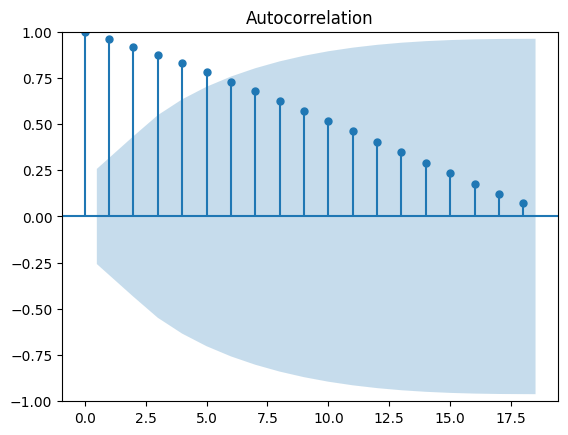

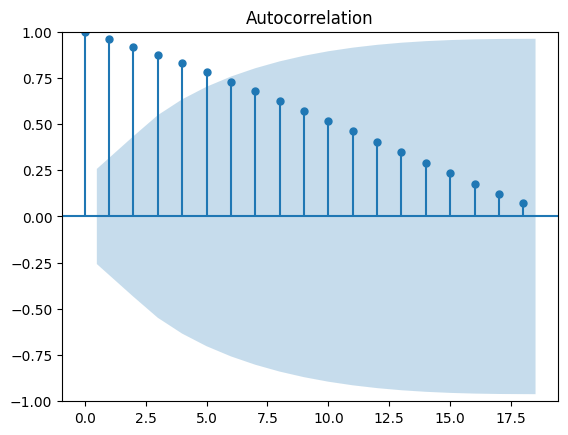

In [1272]:
plot_acf(data[(data['Country']=="Mainland China") & (data['State']=="Hubei")][['Recovered']])

Простая автокорреляция может указывать на косвенную связь и, следовательно, не очень полезна для нас.

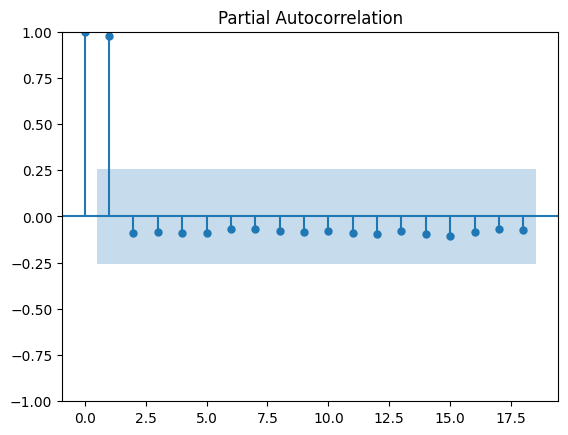

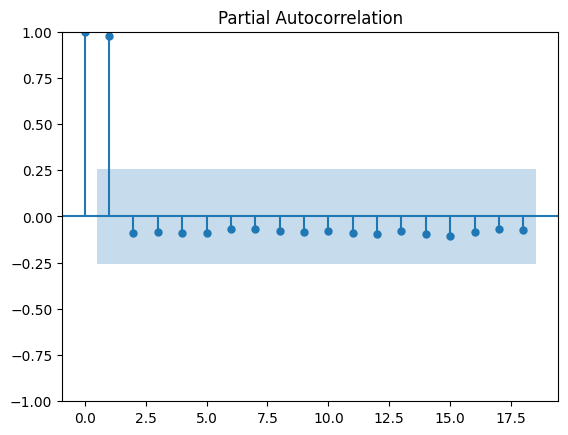

In [1273]:
plot_pacf(data[(data['Country']=="Mainland China") & (data['State']=="Hubei")][['Recovered']])

- Частичная автокорреляция указывает на то, что предыдущий день является важной особенностью. Поэтому мы установим интервал 1

In [1274]:
def simple_fe(df):
    
    df['year']=df['ds'].dt.year
    df['month']=df['ds'].dt.month
    df['day']=df['ds'].dt.day
    
    ##lag features
    df.loc[:,'rec_lag_2']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.shift(1))
    df.loc[:,'conf_lag_2'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.shift(1))
    df.loc[:,'deaths_lag_2'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.shift(1))
    
    ##rolling mean
    df['rec_rollmean_7']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.rolling(7).mean())
    df['conf_rollmean_7'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.rolling(7).mean())
    df['deaths_rollmean_7'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.rolling(7).mean())
    
    ##rolling std
    df['rec_rollstd_7']=df.groupby(['Country','State'])['Recovered'].transform(lambda x: x.rolling(7).std())
    df['conf_rollstd_7'] = df.groupby(['Country'])['Confirmed'].transform(lambda x: x.rolling(7).std())
    df['deaths_rollstd_7'] =df.groupby(['Country'])['Deaths'].transform(lambda x: x.rolling(7).std())
    
    #df.drop(['ds'],axis=1,inplace=True)
    df.fillna(0,inplace=True)
    
    return df
    

In [1275]:
data= simple_fe(data)

In [1276]:
def run_lgb(data,target):
    
    features=['year', 'month','State', 'Country','Recovered',
               'day', 'rec_lag_2', 'conf_lag_2', 'deaths_lag_2',
               'rec_rollmean_7', 'conf_rollmean_7', 'deaths_rollmean_7',
               'rec_rollstd_7', 'conf_rollstd_7', 'deaths_rollstd_7']
     
    train,test=train_test_split(data,7)
    x_train=train[features]
    y_train=train[target]
    print(x_train.shape)
    x_val=test[features]
    y_val=test[target]
    print(x_val.shape)

    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}

    train_set = lgb.Dataset(x_train[features], y_train,categorical_feature=['State',"Country",'year','month','day'])
    val_set = lgb.Dataset(x_val[features], y_val,categorical_feature=['State',"Country",'year','month','day'])

    del x_train, y_train

    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 50, valid_sets = [train_set, val_set],
                      verbose_eval = 100,)
    val_pred = model.predict(x_val[features])
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(val_score)

    return val_pred

In [1277]:
sub=pd.DataFrame()
sub['ds']=test['ds'].values
targets=['Confirmed', 'Deaths', 'Recovered']
for target in targets:
    
        sub[target]=run_lgb(data,target)

(4935, 15)
(1861, 15)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 14
[LightGBM] [Info] Start training from score 577.614590
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 329.901	valid_1's rmse: 1864.7
[200]	training's rmse: 217.33	valid_1's rmse: 1776.81
Early stopping, best iteration is:
[230]	training's rmse: 204.596	valid_1's rmse: 1749.01
1749.0084378900674
(4935, 15)
(1861, 15)
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

In [1278]:
sub.head()

,ds,Confirmed,Deaths,Recovered
0,2020-03-13,66975.511032,2883.008916,47159.350264
1,2020-03-13,2380.014174,76.749838,1253.168885
2,2020-03-13,1620.950441,78.027392,1559.718031
3,2020-03-13,1140.705967,27.218747,1451.331183
4,2020-03-13,1044.094690,22.234836,1258.875826
